In [38]:
from influxdb import InfluxDBClient
import pandas as pd
from skimpy import skim
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [39]:
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread', database='orkney')

In [40]:
generation = client.query('SELECT * FROM Generation WHERE time > now() - 360d;')
wind = client.query("SELECT * FROM MetForecasts WHERE time > now() - 360d and time <= now() and Lead_hours = '1';")

In [41]:
def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values , columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime -index
    return df

In [42]:
gen_data = get_df(generation)
wind_data = get_df(wind)

In [43]:
wind_data.head()

,Direction,Lead_hours,Source_time,Speed
time,,,,
2022-02-24 12:00:00+00:00,W,1,1645696800,9.83488
2022-02-24 15:00:00+00:00,WSW,1,1645707600,12.96416
2022-02-24 18:00:00+00:00,W,1,1645718400,13.85824
2022-02-24 21:00:00+00:00,NNW,1,1645729200,8.04672
2022-02-25 00:00:00+00:00,NNE,1,1645740000,4.91744


In [44]:
gen_data.head()

,ANM,Non-ANM,Total
time,,,
2022-02-24 10:42:00+00:00,13.640999,18.098,31.738999
2022-02-24 10:43:00+00:00,13.562002,18.408,31.970002
2022-02-24 10:44:00+00:00,13.072002,17.488,30.560002
2022-02-24 10:45:00+00:00,13.139002,17.421,30.560002
2022-02-24 10:46:00+00:00,13.810996,18.750,32.560996


In [45]:
# resample gen_data into 3 hour averages
gen_data = gen_data.resample('3H').mean()
gen_data

,ANM,Non-ANM,Total
time,,,
2022-02-24 09:00:00+00:00,11.723807,17.479205,29.203013
2022-02-24 12:00:00+00:00,10.236690,17.709622,27.946312
2022-02-24 15:00:00+00:00,12.263645,15.770578,28.034222
2022-02-24 18:00:00+00:00,7.100500,11.221667,18.322167
2022-02-24 21:00:00+00:00,8.333689,14.413522,22.747211
...,...,...,...
2023-02-18 21:00:00+00:00,2.097053,4.954194,7.051247
2023-02-19 00:00:00+00:00,4.987375,10.023011,15.010387
2023-02-19 03:00:00+00:00,5.683093,10.547728,16.230821


In [46]:
# combine wind and generation data
combined_data = pd.concat([gen_data, wind_data], axis=1)
combined_data

,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed
time,,,,,,,
2022-02-24 09:00:00+00:00,11.723807,17.479205,29.203013,NaN,NaN,NaN,NaN
2022-02-24 12:00:00+00:00,10.236690,17.709622,27.946312,W,1,1.645697e+09,9.83488
2022-02-24 15:00:00+00:00,12.263645,15.770578,28.034222,WSW,1,1.645708e+09,12.96416
2022-02-24 18:00:00+00:00,7.100500,11.221667,18.322167,W,1,1.645718e+09,13.85824
2022-02-24 21:00:00+00:00,8.333689,14.413522,22.747211,NNW,1,1.645729e+09,8.04672
...,...,...,...,...,...,...,...
2023-02-18 21:00:00+00:00,2.097053,4.954194,7.051247,W,1,1.676747e+09,4.91744
2023-02-19 00:00:00+00:00,4.987375,10.023011,15.010387,W,1,1.676758e+09,8.94080
2023-02-19 03:00:00+00:00,5.683093,10.547728,16.230821,WSW,1,1.676768e+09,11.17600


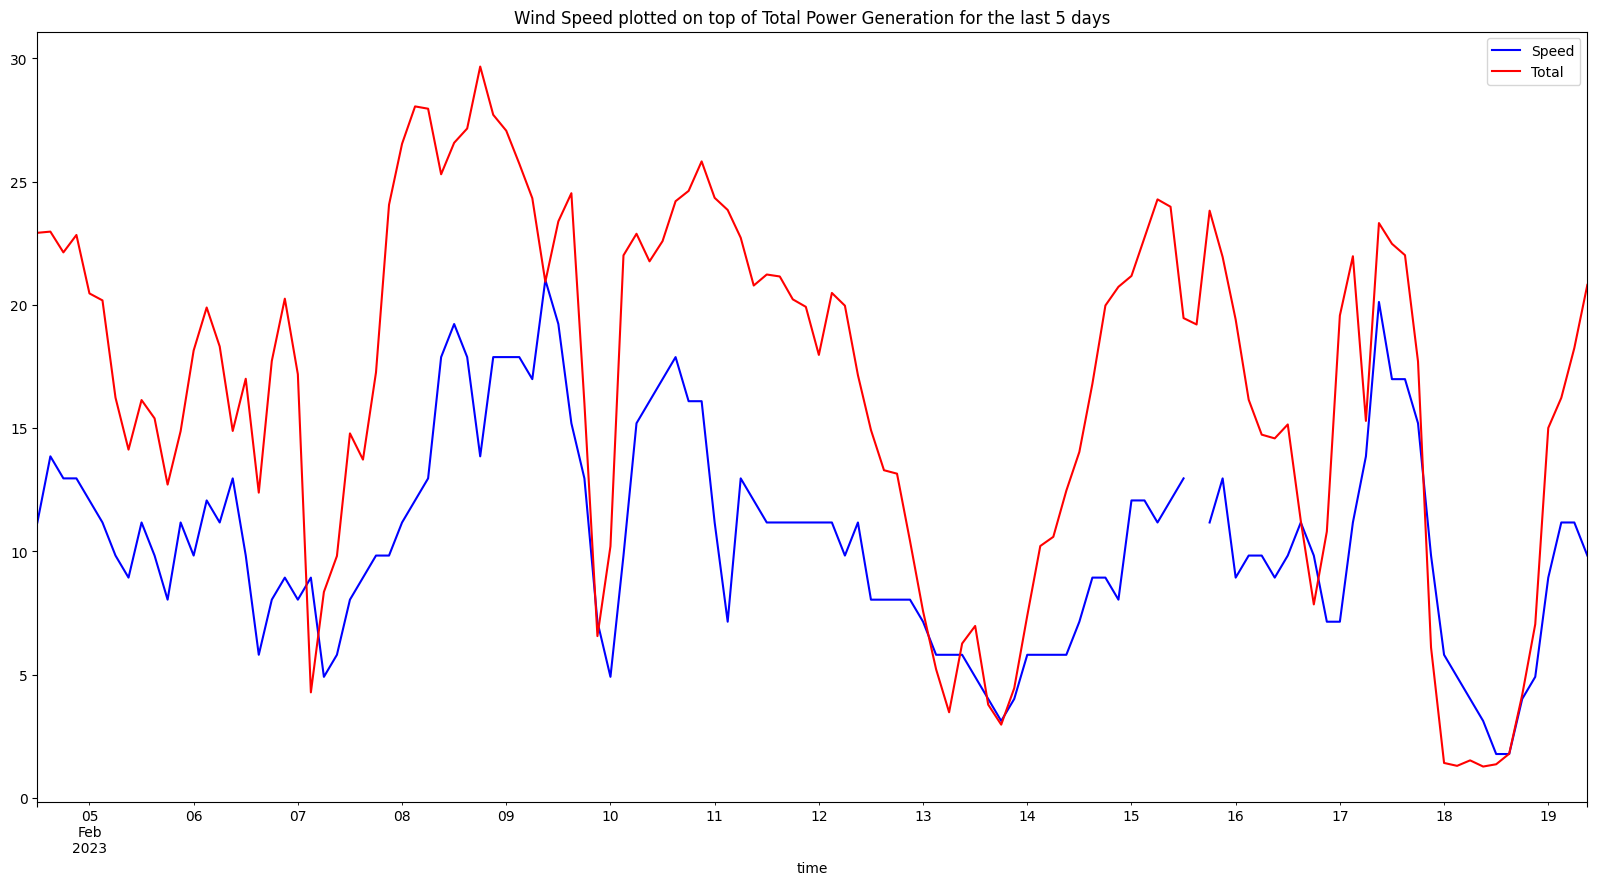

In [47]:
# plot wind speed data ontop of total power generation data but limit to the last 5 days
combined_data['Speed'].tail(120).plot(figsize=(20,10), color='blue')
combined_data['Total'].tail(120).plot(figsize=(20,10), color='red')
plt.legend()
plt.title("Wind Speed plotted on top of Total Power Generation for the last 5 days");

In [48]:
# scatter plot wind speed against wind direction with the power generation as hue
px.scatter(combined_data, x="Direction", y="Speed", color="Total", title="Wind Speed vs Wind Direction with Power Generation as Hue")

In [49]:
# scatter plot Non-ANM vs wind speed
px.scatter(combined_data, x="Speed", y="Non-ANM", title="Non-ANM vs Wind Speed")

In [50]:
# scatter plot windspeed against power generation
px.scatter(combined_data, x="Speed", y="Total", title="Wind Speed vs Power Generation")

In [51]:
# find correlation between Non-ANM power generation and day/night
combined_data['Day'] = combined_data.index.hour
combined_data['Night'] = combined_data.index.hour
combined_data['Night'] = combined_data['Night'].apply(lambda x: 1 if x >= 18 or x <= 6 else 0)
combined_data['Day'] = combined_data['Day'].apply(lambda x: 1 if x > 6 and x < 18 else 0)
combined_data

,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed,Day,Night
time,,,,,,,,,
2022-02-24 09:00:00+00:00,11.723807,17.479205,29.203013,NaN,NaN,NaN,NaN,1,0
2022-02-24 12:00:00+00:00,10.236690,17.709622,27.946312,W,1,1.645697e+09,9.83488,1,0
2022-02-24 15:00:00+00:00,12.263645,15.770578,28.034222,WSW,1,1.645708e+09,12.96416,1,0
2022-02-24 18:00:00+00:00,7.100500,11.221667,18.322167,W,1,1.645718e+09,13.85824,0,1
2022-02-24 21:00:00+00:00,8.333689,14.413522,22.747211,NNW,1,1.645729e+09,8.04672,0,1
...,...,...,...,...,...,...,...,...,...
2023-02-18 21:00:00+00:00,2.097053,4.954194,7.051247,W,1,1.676747e+09,4.91744,0,1
2023-02-19 00:00:00+00:00,4.987375,10.023011,15.010387,W,1,1.676758e+09,8.94080,0,1
2023-02-19 03:00:00+00:00,5.683093,10.547728,16.230821,WSW,1,1.676768e+09,11.17600,0,1


In [52]:
# calcaulate correlation between ANM and day/night
combined_data['ANM'].corr(combined_data['Day'])

0.036756741387820084

In [53]:
combined_data['ANM'].corr(combined_data['Night'])

-0.036756741387820084

In [54]:
# calculate correlation between Non-ANM or ANM, and speed

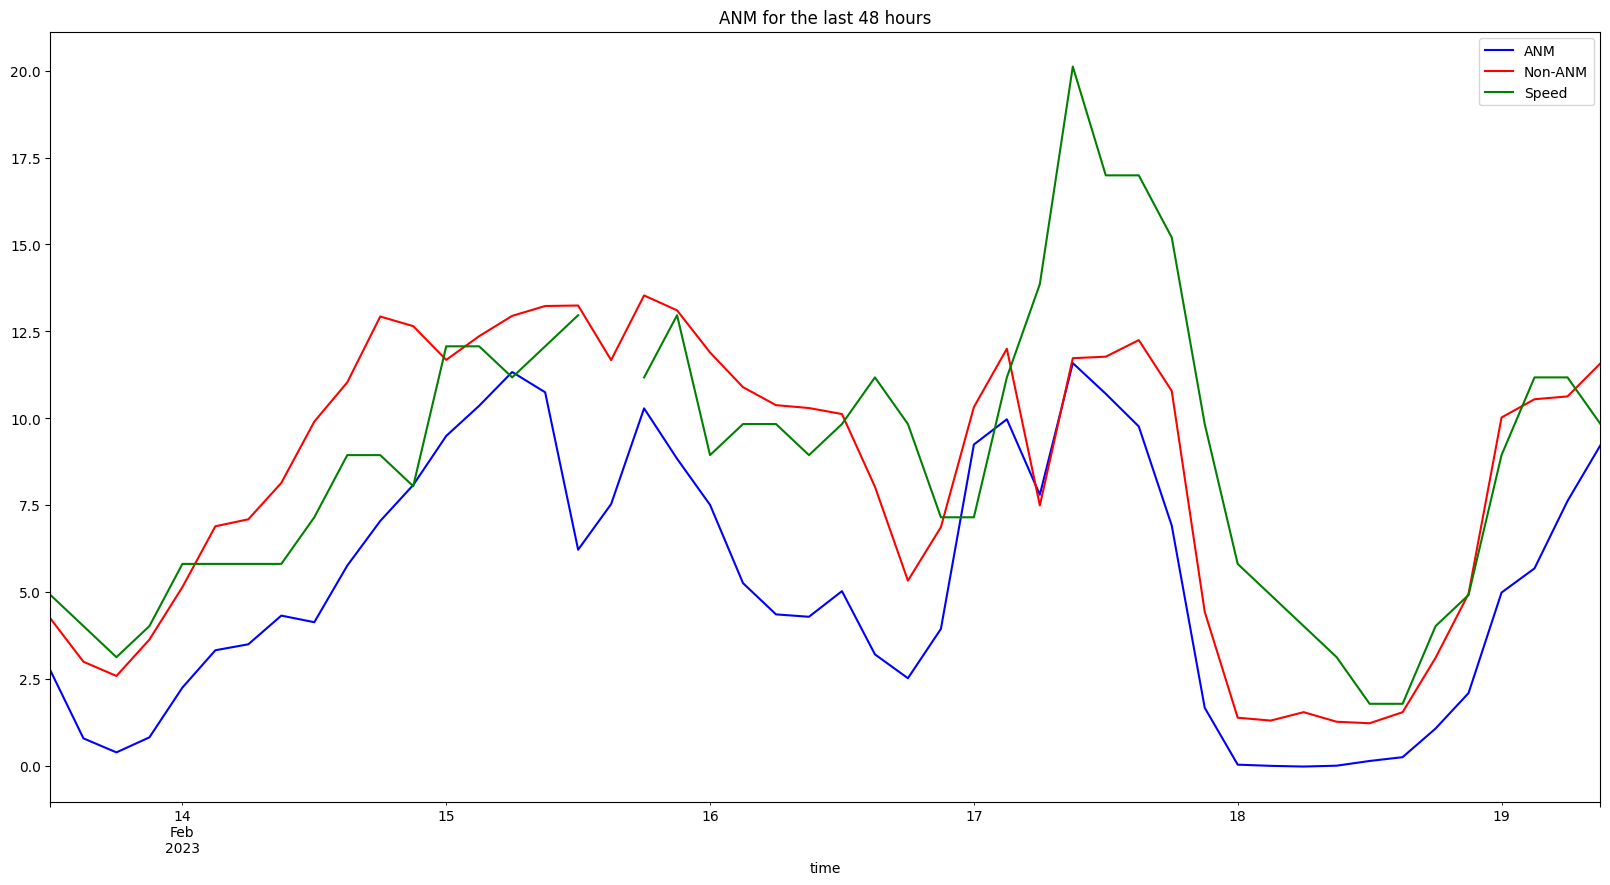

In [55]:
# plot anm for last 48 hours
combined_data['ANM'].tail(48).plot(figsize=(20,10), color='blue')
combined_data['Non-ANM'].tail(48).plot(figsize=(20,10), color='red')
combined_data['Speed'].tail(48).plot(figsize=(20,10), color='green')
plt.legend()
plt.title("ANM for the last 48 hours");

In [56]:
set(wind_data["Direction"])

{'E',
 'ENE',
 'ESE',
 'N',
 'NE',
 'NNE',
 'NNW',
 'NW',
 'S',
 'SE',
 'SSE',
 'SSW',
 'SW',
 'W',
 'WNW',
 'WSW'}

In [57]:
# map discrete wind directions to degrees
wind_directions = {
    "N": 0,
    "NNE": 22.5,
    "NE": 45,
    "ENE": 67.5,
    "E": 90,
    "ESE": 112.5,
    "SE": 135,
    "SSE": 157.5,
    "S": 180,
    "SSW": 202.5,
    "SW": 225,
    "WSW": 247.5,
    "W": 270,
    "WNW": 292.5,
    "NW": 315,
    "NNW": 337.5,
}

In [58]:
# apply mapping to wind combined data
combined_data["Direction"] = combined_data["Direction"].map(wind_directions)
combined_data

,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed,Day,Night
time,,,,,,,,,
2022-02-24 09:00:00+00:00,11.723807,17.479205,29.203013,NaN,NaN,NaN,NaN,1,0
2022-02-24 12:00:00+00:00,10.236690,17.709622,27.946312,270.0,1,1.645697e+09,9.83488,1,0
2022-02-24 15:00:00+00:00,12.263645,15.770578,28.034222,247.5,1,1.645708e+09,12.96416,1,0
2022-02-24 18:00:00+00:00,7.100500,11.221667,18.322167,270.0,1,1.645718e+09,13.85824,0,1
2022-02-24 21:00:00+00:00,8.333689,14.413522,22.747211,337.5,1,1.645729e+09,8.04672,0,1
...,...,...,...,...,...,...,...,...,...
2023-02-18 21:00:00+00:00,2.097053,4.954194,7.051247,270.0,1,1.676747e+09,4.91744,0,1
2023-02-19 00:00:00+00:00,4.987375,10.023011,15.010387,270.0,1,1.676758e+09,8.94080,0,1
2023-02-19 03:00:00+00:00,5.683093,10.547728,16.230821,247.5,1,1.676768e+09,11.17600,0,1


In [59]:
# Import the required packages
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from math import pi
# Uncomment the following line in case you are missing those packages
from windrose import WindroseAxes

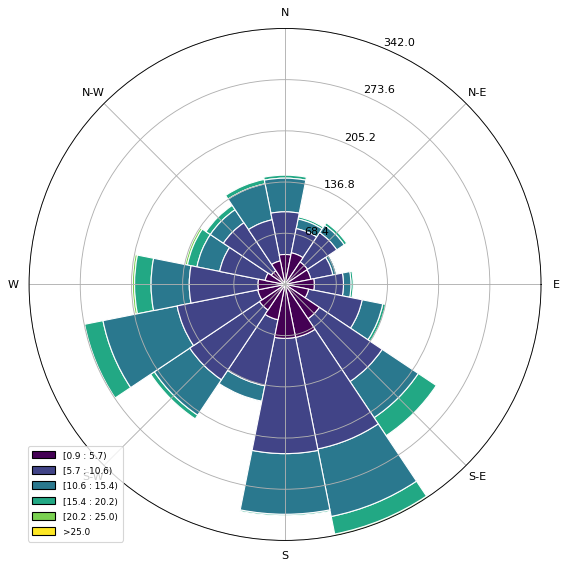

In [60]:
ax = WindroseAxes.from_ax()
ax.bar(combined_data.Direction, combined_data.Speed, normed=False, opening=1, edgecolor='white')
ax.set_legend()

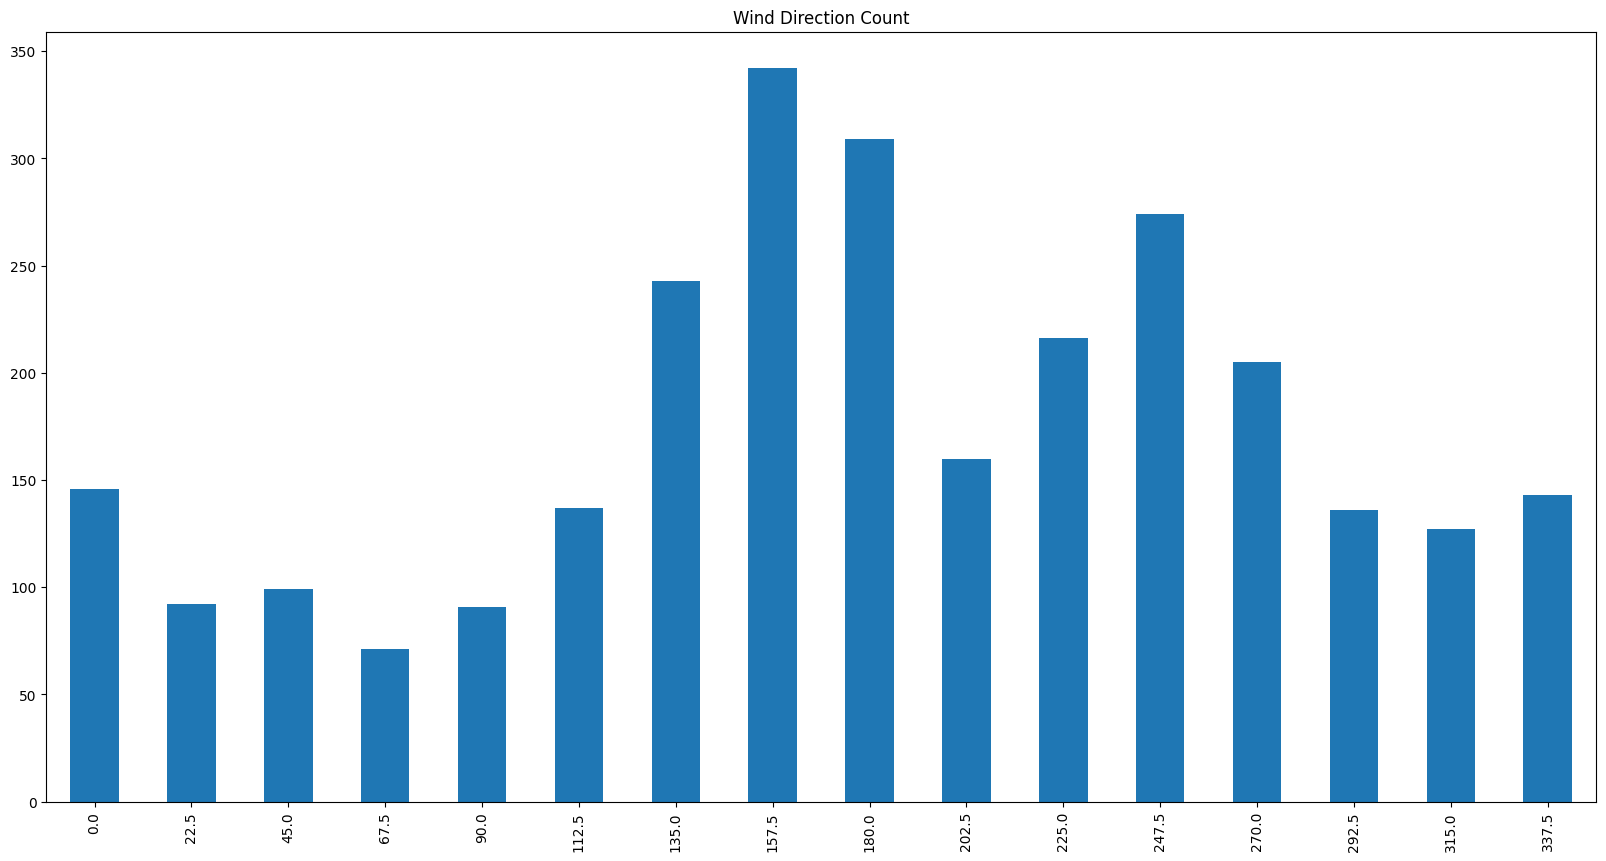

In [61]:
# bar plot wind direction count, sort by direction from 0 to 360
combined_data["Direction"].value_counts().sort_index().plot(kind="bar", figsize=(20,10), title="Wind Direction Count");